# Topic predicton on Reutuers Dataset

create a model that predicts the topic / topics of the given text

In [76]:
import pandas as pd
import numpy as np
dataset = pd.read_csv("Reuters/reuters21578_news.csv")
dataset.head()

,Unnamed: 0,newID,oldID,title,author,data_split,isTopicsAvailable,document_date,dateline,people,places,orgs,exchanges,topic_body,topics
0,0,1,5544,BAHIA COCOA REVIEW,NaN,TRAIN,YES,26-FEB-1987 15:01:01.79,"SALVADOR, Feb 26 -",[],"['el-salvador', 'usa', 'uruguay']",[],[],Showers continued throughout the week in\nthe ...,['cocoa']
1,1,2,5545,STANDARD OIL <SRD> TO FORM FINANCIAL UNIT,NaN,TRAIN,NO,26-FEB-1987 15:02:20.00,"CLEVELAND, Feb 26 -",[],['usa'],[],[],Standard Oil Co and BP North America\nInc said...,NaN
2,2,3,5546,TEXAS COMMERCE BANCSHARES <TCB> FILES PLAN,NaN,TRAIN,NO,26-FEB-1987 15:03:27.51,"HOUSTON, Feb 26 -",[],['usa'],[],[],Texas Commerce Bancshares Inc's Texas\nCommerc...,NaN
3,3,4,5547,TALKING POINT/BANKAMERICA <BAC> EQUITY OFFER,"by Janie Gabbett, Reuters",TRAIN,NO,26-FEB-1987 15:07:13.72,"LOS ANGELES, Feb 26 -",[],"['usa', 'brazil']",[],[],BankAmerica Corp is not under\npressure to act...,NaN
4,4,5,5548,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,NaN,TRAIN,YES,26-FEB-1987 15:10:44.60,"WASHINGTON, Feb 26 -",[],['usa'],[],[],The U.S. Agriculture Department\nreported the ...,"['grain', 'wheat', 'corn', 'barley', 'oat', 's..."


In [77]:
data = dataset[["title", "topic_body", "topics"]].rename(columns={"topic_body": "text"})
data = data.drop(axis=1, columns=["title"])
data = data.dropna()
print(f"amount of documents: {len(data)}")
data["length"] = data["text"].apply(len)
data.head()

amount of documents: 10377


,text,topics,length
0,Showers continued throughout the week in\nthe ...,['cocoa'],2859
4,The U.S. Agriculture Department\nreported the ...,"['grain', 'wheat', 'corn', 'barley', 'oat', 's...",1140
5,Argentine grain board figures show\ncrop regis...,"['veg-oil', 'linseed', 'lin-oil', 'soy-oil', '...",1263
8,Champion Products Inc said its\nboard of direc...,['earn'],339
9,Computer Terminal Systems Inc said\nit has com...,['acq'],1263


In [78]:
## preprocessing text
import string
import wordninja
exculude = string.punctuation
# to lowercase
data["text"] = data["text"].str.lower()
# remove newline, tabs, numbers
data["text"] = data["text"].replace('[\n\t\'0-9]', '', regex=True)
# remove puncutation
data["text"] = data["text"].apply(lambda s: s.translate(str.maketrans('', '', exculude)))
# split joined words
data["text"] = data["text"].apply(lambda s: " ".join(wordninja.split(s)))
data.head()

,text,topics,length
0,showers continued throughout the week in the b...,['cocoa'],2859
4,the us agriculture department reported the far...,"['grain', 'wheat', 'corn', 'barley', 'oat', 's...",1140
5,argentine grain board figures show crop regist...,"['veg-oil', 'linseed', 'lin-oil', 'soy-oil', '...",1263
8,champion products inc said its board of direct...,['earn'],339
9,computer terminal systems inc said it has comp...,['acq'],1263


<Axes: xlabel='length', ylabel='count'>

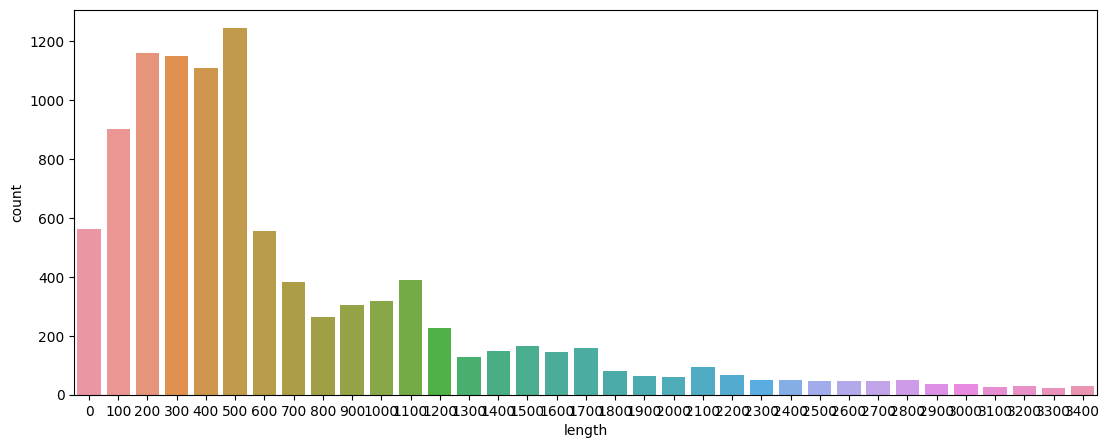

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(13.2,5))
sns.countplot(data=data[data["length"] < 3500][["length"]].apply(lambda x: (x // 100) * 100), x="length", ax=ax)

In [80]:
# process topics
data["topics"] = data["topics"].replace('[\',]', '', regex=True)
for idx, row in data.iterrows():
    topics = data["topics"][idx][1:-1].split()
    data.loc[idx, "topics"] = topics[0]
    if len(topics) > 1:
        data.loc[idx, "multi-topic"] = True

data["multi-topic"] = data["multi-topic"].fillna(False)
data = data.reset_index(drop=True)
data.head()

,text,topics,length,multi-topic
0,showers continued throughout the week in the b...,cocoa,2859,False
1,the us agriculture department reported the far...,grain,1140,True
2,argentine grain board figures show crop regist...,veg-oil,1263,True
3,champion products inc said its board of direct...,earn,339,False
4,computer terminal systems inc said it has comp...,acq,1263,False


In [81]:
# only keep where we have more than 100 of the same topic
df = data[data.groupby("topics").topics.transform('count') >= SIZE // 20]
df = df.reset_index(drop=True)
df.head()

,text,topics,length,multi-topic
0,showers continued throughout the week in the b...,cocoa,2859,False
1,the us agriculture department reported the far...,grain,1140,True
2,argentine grain board figures show crop regist...,veg-oil,1263,True
3,champion products inc said its board of direct...,earn,339,False
4,computer terminal systems inc said it has comp...,acq,1263,False


Amount of data after processing: 9597


<Axes: xlabel='topics', ylabel='count'>

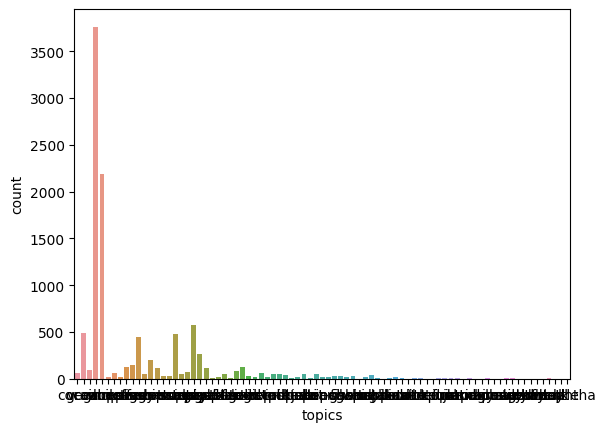

In [82]:
print(f"Amount of data after processing: {len(df)}")
sns.countplot(data=data, x="topics")

In [83]:
# prepare for model training
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df["text"], df["topics"], test_size=0.2, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7677,)
(1920,)
(7677,)
(1920,)


In [60]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoded_y_train = encoder.fit_transform(y_train)
encoded_y_test = encoder.transform(y_test)
encoder_maps = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

# encode text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectoriser = CountVectorizer(ngram_range=(1,1))
encoded_X_train = vectoriser.fit_transform(X_train).toarray()
encoded_X_test = vectoriser.transform(X_test).toarray()

In [61]:
# one hot encode text
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
vocab_size = 50
max_length = df['text'].apply(len).max()
# one_hot_encoder = np.vectorize(lambda t: one_hot(t, vocab_size))
# one_hot_encoder(X_train[:2])
one_hot_X_train = [one_hot(t, vocab_size) for t in X_train]
one_hot_X_test = [one_hot(t, vocab_size) for t in X_test]

encoded_X_train = pad_sequences(one_hot_X_train, maxlen=max_length, padding="post")
encoded_X_test = pad_sequences(one_hot_X_test, maxlen=max_length, padding="post")

In [62]:
np.save("X_train.npy", encoded_X_train)
np.save("X_test.npy", encoded_X_test)
np.save("y_train.npy", encoded_y_train)
np.save("y_test.npy", encoded_y_test)

In [63]:
encoded_X_train = np.load("X_train.npy")
encoded_X_test = np.load("X_test.npy")
encoded_y_train = np.load("y_train.npy")
encoded_y_test = np.load("y_test.npy")

In [69]:
TRAIN_LIMIT = 100
TEST_LIMIT = 10

eX_train = encoded_X_train[:TRAIN_LIMIT]
eX_test = encoded_X_test[:TEST_LIMIT]
ey_train = encoded_y_train[:TRAIN_LIMIT]
ey_test = encoded_y_test[:TEST_LIMIT]

In [70]:
# model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten
from tensorflow.keras.utils import to_categorical

topics = len(df['topics'].unique())
# topics_shape = y_train.shape[1]


model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=512, input_length=max_length),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
])


model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 6085, 512)         25600     
                                                                 
 flatten_2 (Flatten)         (None, 3115520)           0         
                                                                 
 dense_10 (Dense)            (None, 64)                199393344 
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 199419009 (760.72 MB)
Trainable params: 199419009 (760.72 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [71]:
model.evaluate(eX_test, ey_test)

1/1 [==============================] - 0s 250ms/step - loss: 0.5635 - accuracy: 0.0000e+00


[0.5635059475898743, 0.0]

In [72]:
history = model.fit(eX_train, ey_train, epochs=10, batch_size=10, validation_split=0.1)

Epoch 1/10
9/9 [==============================] - 13s 1s/step - loss: -8525.5781 - accuracy: 0.0000e+00 - val_loss: -14179.0703 - val_accuracy: 0.0000e+00
Epoch 2/10
9/9 [==============================] - 12s 1s/step - loss: -44965.0430 - accuracy: 0.0000e+00 - val_loss: -39977.8867 - val_accuracy: 0.0000e+00
Epoch 3/10
9/9 [==============================] - 12s 1s/step - loss: -102769.5078 - accuracy: 0.0000e+00 - val_loss: -83265.6094 - val_accuracy: 0.0000e+00
Epoch 4/10
9/9 [==============================] - 12s 1s/step - loss: -193984.4844 - accuracy: 0.0000e+00 - val_loss: -150656.2031 - val_accuracy: 0.0000e+00
Epoch 5/10
9/9 [==============================] - 12s 1s/step - loss: -337939.1562 - accuracy: 0.0000e+00 - val_loss: -248852.6562 - val_accuracy: 0.0000e+00
Epoch 6/10
9/9 [==============================] - 12s 1s/step - loss: -531301.8750 - accuracy: 0.0000e+00 - val_loss: -389414.4062 - val_accuracy: 0.0000e+00
Epoch 7/10
9/9 [==============================] - 12s 1s/s

/tmp/ipykernel_5261/2291758319.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


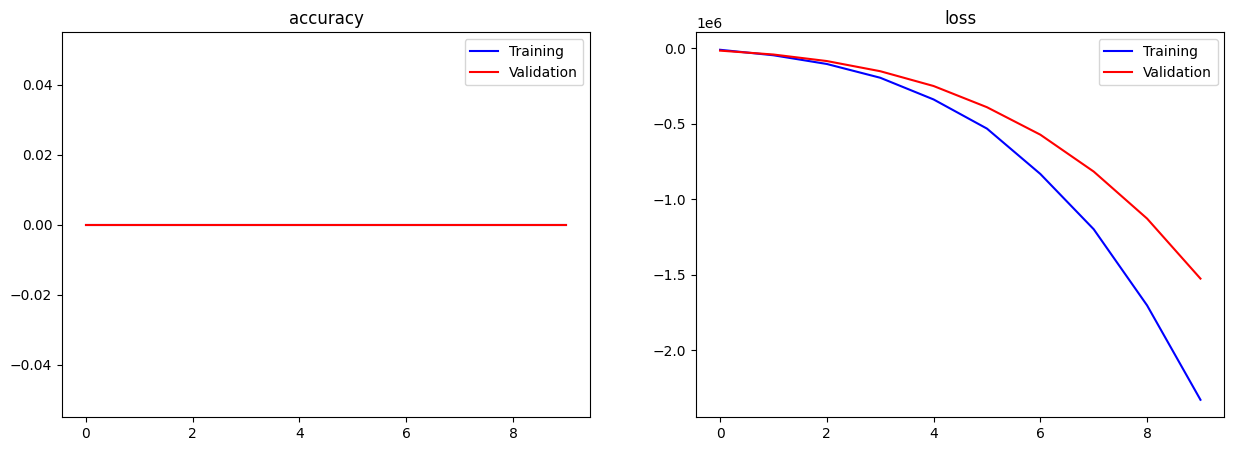

In [73]:
def plot_learning_curves(history):
    acc      = history.history["accuracy"]
    val_acc  = history.history["val_accuracy"]
    loss     = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(len(acc))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    ax1.plot(epochs, acc, "b", label="Training")
    ax1.plot(epochs, val_acc, "r", label="Validation")
    ax1.set_title("accuracy")
    ax1.legend()
    
    ax2.plot(epochs, loss, "b", label="Training")
    ax2.plot(epochs, val_loss, "r", label="Validation")
    ax2.set_title("loss")
    ax2.legend()

    fig.show()

plot_learning_curves(history)

In [74]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 140ms/step - loss: -2049142.6250 - accuracy: 0.0000e+00


[-2049142.625, 0.0]

In [86]:
sample_index = 1
sample_input = X_test.iloc[sample_index]
encoded_sample = encoded_X_test[sample_index]
print("Example Input:", sample_input)
print("Encoded Vector:", encoded_sample[:100])

predicted_class = np.max(model.predict(np.array([encoded_sample])))
actual_class = ey_test[sample_index]

print("Predicted Class:", predicted_class, list(encoder_maps.keys())[list(encoder_maps.values()).index(int(predicted_class))])
print("Actual Class:", actual_class, list(encoder_maps.keys())[list(encoder_maps.values()).index(actual_class)])



Example Input: said its shareholders approved its merger into and its change of incorporation from nevada to delaware metro funding also said its subsidiary comet corp will be renamed max com usa the company also reported shareholders approved the authorization of shares of common stock to be set aside for an incentive stock option plan reuter
Encoded Vector: [28 34  7  6 34 12 22 12 34 11 30 28 35 25  7 37 34 34 26 28 34  4  7 13
 19  9 30 16  6 12 10 15 26 12  7  6 10 13 30 45 30  8 10  7  9 38 29 20
 43 17 10 29 18  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]
1/1 [==============================] - 0s 51ms/step
Predicted Class: 1.0 cocoa
Actual Class: 0 acq


In [87]:
list(encoder_maps.keys())[list(encoder_maps.values()).index(1)]

'cocoa'